In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Normal Distribution
It's a univariate probability distribution for continous real random variable.  
mean $\mu$ and standard deviation $\sigma$ are the distribution paramters. 
Probability density function is given by,  

$$ f(x) = \frac{1}{\sigma \sqrt{2\pi}} \exp{-\frac{1}{2}\left[\frac{x - \mu}{\sigma}\right]^2}$$

In [2]:
class Normal(object):
    def __init__(self, mean = None, var = None):
        """
        mean and varience which are parameters of Normal Distribution, 
        are the attributes for this class.
        """
        self.mean = mean
        self.var  = var
        
    def pdf(self, x):
        """
        Function takes real number x as input and returns probability density 
        value curresponding to it.
        If distribution parameters are not defiend it will raise an error
        """
        if self.mean is None or self.var is None:
            raise Exception('Distribution Parameters are not set')
        
        sigma = np.sqrt(self.var)
        mu  = self.mean
        
        f = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-1/2 * ((x - mu) / sigma)**2)
        return f
    
    def logLH(self, x):
        """
        Function takes real number x as input and returns log of probability 
        density value curresponding to it.
        if distribution parameters are not defiend it will raise an error
        """
        if self.mean is None or self.var is None:
            raise Exception('Distribution Parameters are not set')
        
        return np.log10(self.pdf(x))
    
    def fit(self, X):
        """
        Function takes array of realisations of random variable and sets values 
        of distribution parameters by their estimates based on data
        """
        self.mean = np.mean(X)
        self.var  = np.var(X)
    
    def plot(self):
        """
        Function Plots the density function
        If distribution parameters are not defiend it will raise an error
        """      
        if self.mean is None or self.var is None:
            raise Exception('Distribution Parameters are not set')
            
        sigma = np.sqrt(self.var)
        mu  = self.mean
        
        x = np.linspace( (mu - 3*sigma) , (mu + 3*sigma), 100)
        y = self.pdf(x)
        
        plt.plot(x,y)
        plt.show()
        
    def __str__(self):
        if self.mean is None or self.var is None:
            return 'Distribution Parameters are not set'
        else:
            return "Normal distribution with mean " + str('{:.2e}'.format(self.mean)) + " and varience " + str('{:.2e}'.format(self.var))

### Understanding the class

In [3]:
# Initialising class with parameters
dist = Normal(mean = 0, var = 1)
print(dist)

Normal distribution with mean 0.00e+00 and varience 1.00e+00


In [4]:
# Probability density value 
x = 0.5
fx = dist.pdf(x)
print('Probability density value at ', x,' is ', fx)

Probability density value at  0.5  is  0.3520653267642995


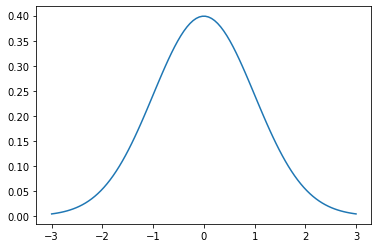

In [5]:
dist.plot()

In [6]:
# Initialising class without parameters
distribution = Normal()
print(distribution)

Distribution Parameters are not set


In [7]:
# Fitting Probability density function paramters from data 
X = np.random.normal(0, 1, 1000)
distribution.fit(X)
print(distribution)

Normal distribution with mean 3.01e-02 and varience 9.49e-01


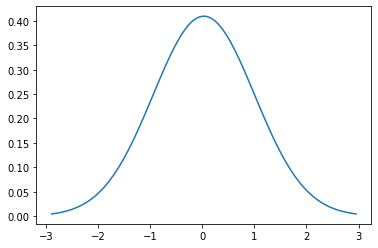

In [8]:
distribution.plot()

## Naive Bayes
Baye's theorem for event A and B is given by,  
$$ P(B|A) = \frac{P(A|B)P(B)}{P(A)} $$  

For classification problem we want label $y$ based on values of set of attributes $X = \{x_1, x_2,..., x_n\}$. above formula can be written as,  
$$ P(y|\{x_1, x_2,..., x_n\}) = \frac{P(\{x_1, x_2,..., x_n\}|y)P(y)}{P(\{x_1, x_2,..., x_n\})} $$   

Assuming atributes are independant, 
$$ P(y|\{x_1, x_2,..., x_n\}) = \frac{P(x_1|y).P(x_2|y)...P(x_n|y)P(y)}{P(\{x_1, x_2,..., x_n\})} $$  

Probability of y taking specific value $y_1$ for given set of attributes $X = \{x_1, x_2,..., x_n\}$ is given by,  

$$ P(y=y_1|\{x_1, x_2,..., x_n\}) = \frac{P(y=y_1)P(x_1|y=y_1).P(x_2|y=y_1)...P(x_n|y=y_1)}{P(\{x_1, x_2,..., x_n\})} $$ 

Similarly, Probability for each possible value of y can be computed and compared to make prediction.  
As denominator is independant of value of y, it can be ignored. we get following equation. 

$$ P(y=y_1|\{x_1, x_2,..., x_n\}) \propto P(y=y_1) \prod_{i = 1}^{n}{P(x_i|y=y_1)} $$ 

Prediction can be written as,

$$ \hat{y} = argmax_y \left[P(y=y_1) \prod_{i = 1}^{n}{P(x_i|y=y_1)}\right] $$

In [9]:
class NaiveBayes(object):
    def __init__(self):
        """
        self.categories - list of output categories
        self.attributes - list of attributes
        self.condP - dataframe, which contains the conditional probability distribution 
                     for each attribute with each category
                     condP.loc[attribute,category] = P(attribute|category)
        self.catgP - dictionary of probability of each category
        """
        self.categories = None
        self.attributes = None
        self.condP = None
        self.catgP = None

    def fit(self, X, Y, dist):
        """
        Input:
        X - Pandas dataframe where each row is set of attributes for an example.
        Y - Pandas series with labels curresponding to X
        dist - distribution class
        
        With given inputes this function fills the attributes of the NaiveBayes class
        """

        self.categories = list(np.unique(Y))
        self.attributes = list(X.columns)
        
        att, cat = len(self.attributes), len(self.categories)
        
        # dataframe with probability distribution of each attribute given a category
        condP = pd.DataFrame(np.zeros((att, cat)), columns = self.categories, index = self.attributes)
        for attribute in self.attributes:
            for category in self.categories:
                # data vector of specific attribute curresponding to specific category
                dataVec = X.loc[Y == category, attribute]
                
                # Creating an instance of distribution and fitting with estimates of parameters
                condP.loc[attribute,category] = dist()
                condP.loc[attribute,category].fit(dataVec)
                
        self.condP = condP
        
        # dictionary with probability for each category
        catgP = {}
        for category in self.categories:
            catgP[category] = sum(Y == category)/len(Y)
        self.catgP = catgP
    
    def model(self, X):
        """
        Input:
        X - pandas series with set of attributes
        Output:
        function returns predicted label based on given set of attributes
        """
        # Dictionary with predicted probability of each class given set of attributes
        predProb = {}
        for category in self.categories:
            predProb[category] = np.log10(self.catgP[category])
            for attribute in self.attributes:
                # log likelyhood of each attribute value for given category
                logLH = self.condP.loc[attribute,category].logLH(X[attribute]) 
                predProb[category] = predProb[category] + logLH
                
        return max(predProb, key = predProb.get)
    
    def predict(self, Xlist):
        row, col = Xlist.shape
        pred = []
        for each in range(row):
            pred.append(self.model(Xlist.iloc[each,]))
        return pred

In [10]:
df = pd.read_csv('iris.csv')
df = df.sample(frac = 1) 

In [11]:
row, col = df.shape
frac  = row//5
train = df.iloc[frac:,]
test  = df.iloc[:frac,]

In [12]:
X_train = train.iloc[:,range(col-1)]
Y_train = train.iloc[:,col-1]
X_test  = test.iloc[:,range(col-1)]
Y_test  = test.iloc[:,col-1]

In [13]:
# Creating an instance of the NaiveBayes class
NB = NaiveBayes()

# Generating model based on data with Normal distribution assumption
NB.fit(X_train,Y_train,Normal)

In [14]:
# Prediction using NaiveBayes
Y_pred = NB.predict(X_test)

# Calculating accuracy
Accuracy = sum(Y_pred == Y_test)/len(Y_test)
print('Accuracy of prediction is ', round(Accuracy*100,2),'%' )

Accuracy of prediction is  96.67 %
